# Kaggle course : feature engineering

For a feature to be useful, it must have a relationship to the target that your model is able to learn. Linear models, for instance, are only able to learn linear relationships.

In [10]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import cv2

In [11]:
from sklearn.feature_selection import mutual_info_regression

### Mutal information 


The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

<br />

<li>MI can help you to understand the <strong>relative potential of a feature</strong> as a predictor of the target, considered by itself.</li>
<li>It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a <strong>univariate</strong> metric.</li>
<li>The actual <strong>usefulness of a feature depends on the model you use it with</strong>. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.</li>

The scikit-learn mutal information algorithm treats discrete features differently from continuous features:
<li>anything that must have a float dtype is not discrete</li>
<li>'object' or 'categorical' dtype can be treated as discrete using label encoding</li>

In [73]:
def make_mi_scores(X, y, discrete_features:bool):
    # mutual_info_regression and mutual_info_classification
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

## Creating features

In [13]:
# mathematical transforms : applying arithmetic operations to columns (as if they were ordinary numbers)
# for example by creating ratios 
autos["stroke_ratio"] = autos.stroke / autos.bore
autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


### data visualization can suggest transformation => features with skewed distributions.

A feature with a "skewed" distribution means that the data points are not symmetrically distributed around the mean, but instead are concentrated more on one side than the other.

!["Skewness of a distribution"](images/skewness.png)

There are two types of skewness:
<ul>
    <li>Positive (right) skew:
        <ul>
            <li>the tail of the distribution extends towards the right</li>
            <li>most values cluster on the left</li>
            <li>the mean is greater than the median (mean - median = positive)</li>
            <li>ex: income distribution in many countries (many people have lower incomes, fewer have a very high incomes)</li>
        </ul>
    </li>
    <li>Negative (left) skew:
        <ul>
            <li>the tail of the distribution extends towards the left</li>
            <li>most values cluster on the right</li>
            <li>the mean is less than the median (mean - median = negative)</li>
            <li>ex: age at death in developed countries (most people live to old age, fewer die young)</li>
        </ul>
    </li>    
</ul>


`Skewness is important` beacause :
<ol>
    <li>it can affect model performance</li>
    <li>many algorithms assume normally distributed (non-skewed data)</li>
    <li>it might require data transformation to handle effectively</li>
    <li>it can indicate outliers or unsusual patterns in your data</li>
</ol>

Techniques to handle skewed features:
<ul>
    <li>log transformation</li>
    <li>square root transformation</li>
    <li>box-cox transformation</li>
    <li>winsorization for extreme values</li>
</ul>

In [14]:
# example handling the skewness of a feature by applying a log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

NameError: name 'accidents' is not defined

In [15]:
# counts : example by summing  
"""
Features describing the presence or absence of something often come in sets, 
the set of risk factors for a disease, say. 
You can aggregate such features by creating a count
"""
# summing for each row the boolean values of roadway features
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1) 

# 
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

NameError: name 'accidents' is not defined

In [ ]:
# breaking down features

customer[["Type", "Level"]] = (  # Create two new features
    customer["Policy"]           # from the Policy feature
    .str                         # through the string accessor
    .split(" ", expand=True)     # by splitting on " "
                                 # and expanding the result into separate columns
)

# building up features 

autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]

In [ ]:
# group transforms

# mean income by state
customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)

# frequency with which each state occurs in the dataset
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)


## Clustering with K-Means

Adding cluster labels will break up complicated relationshpis accross features into simpler chunks. The model can then simply learn the smaller chunks one by one. Its a "divide and conquer" strategy.

!["Clustering with k-means"](images/clustering.png)

There are a great many clustering algorithms. They differ primarily in how they measure "similarity" or "proximity" and in what kinds of features they work with.


K-means clustering measures similarity using ordinary straight-line distance (Euclidean distance, in other words). It creates clusters by placing a number of points, called centroids, inside the feature-space. Each point in the dataset is assigned to the cluster of whichever centroid it's closest to. The "k" in "k-means" is how many centroids (that is, clusters) it creates. You define the k yourself


<img src="images/kmeans-centroids.png" alt="K-means centroids" width="200" height="300" />

#### K-means learning process and parameters:

1. Process: 
The algorithm starts by randomly initializing some predefined number (n_clusters) of centroids. It then iterates over these two operations:
<ul>
    <li>assign points to the nearest cluster centroid</li>
    <li>move each centroid to minimize the distance to its points</li>
</ul>

2. Parameters:
<ul>
    <li>n_clusters: number of centroids "k"</li>
    <li>max_iter: the amount of iterations of the two steps defined in the process</li>
    <li>n_init: the amount of time the algorithm should be repeated (to prevend poor performance due to the random initialization of the centroids)</li>
</ul>    
    

In [ ]:
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

# plotting to see the effectiveness of the clustering
sns.relplot(
    x="Longitude", y="Latitude", hue="Cluster", data=X, height=6,
)

## Principal component analysis


This, in fact, is the whole idea of PCA: <em>"instead of describing the data with the original features, we describe it with its axes of variation"</em>
<br>

Technical note: PCA is typically applied to standardized data (data where the mean is zero and the standard deviation is 1)

!["pca"](images/pca.png)

<em>The new features PCA constructs are actually just linear combinations (weighted sums) of the original features</em>
<ul>
    <li>These new features are called the principal components of the data.</li>
    <li>The weights themselves are called loadings.</li>
</ul>

### PCA for feature engineering

There are two ways you could use PCA for feature engineering.<br>

<ol>
    <li>The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of 'Height' and 'Diameter' if 'Size' is important, say, or a ratio of 'Height' and 'Diameter' if Shape is important. You could even try clustering on one or more of the high-scoring components.</li><br>
    <li>The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:
        <ul>
            <li>Dimensionality reduction: When your features are highly redundant (multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.</li>
            <li>Anomaly detection: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.</li>
            <li>Noise reduction: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.</li>
            <li>Decorrelation: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.</li>
        </ul>
    </li>
</ol>

In [43]:
from sklearn.decomposition import PCA

In [30]:
autos = pd.read_csv("data/feature_engineering/autos.csv")
X = autos.copy()
y = X.pop('price')

In [37]:

features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]
X = X.loc[:, features]
X.head()

,highway_mpg,engine_size,horsepower,curb_weight
0,27,130,111,2548
1,27,130,111,2548
2,26,152,154,2823
3,30,109,102,2337
4,22,136,115,2824


In [47]:
# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

# # Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
# print(X_pca.shape)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_pca.head()


,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


!["pca example"](images/pca-example-table.png)

In [56]:

loadings = pd.DataFrame(
    data=pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=pca.feature_names_in_,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


In [75]:
def plot_variance(pca):
    fig , axs = plt.subplots(1,2)
    n = pca.n_components_
    grid = np.arange(1, n +1)
    
    # explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid,evr)    
    axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
    
    # cumulative variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0,grid],np.r_[0,cv] )
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    fig.set(figwidth=8, dpi=100)    
    

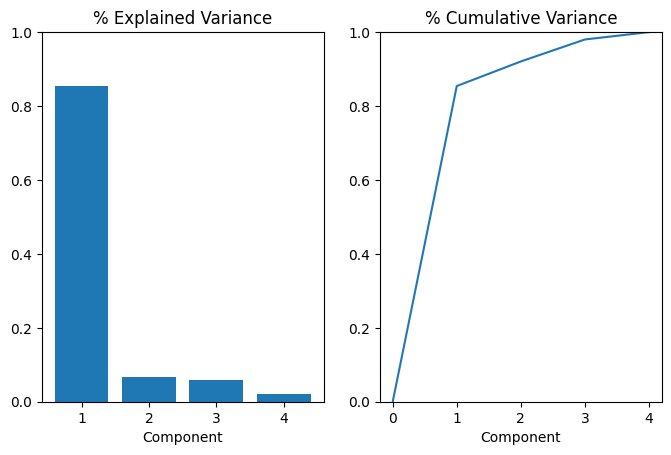

In [76]:
plot_variance(pca)

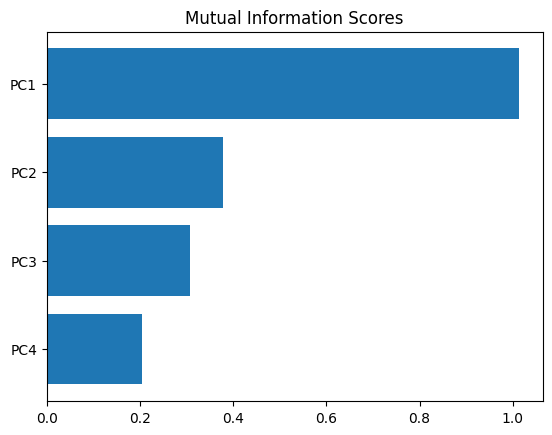

In [93]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
plot_mi_scores(mi_scores)